<a href="https://colab.research.google.com/github/konkoniknik/RL_BartoSutton/blob/main/RL_BartoSutton_Part1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Better implemenation of the world etc. Continuing with the next chapters

In [ ]:
import random
import numpy as np

class GridworldWithWalls:
    def __init__(self, size=10, walls=None, wall_penalty=-100):
        self.size = size
        self.reset()
        if walls is None:
            walls = [(3,0),(3,1),(3,2),(3, 3), (3, 4), (3, 5) ]  # Default wall positions
        self.walls = set(walls)
        self.wall_penalty = wall_penalty

        self.rewards=np.zeros([10,10])
        self.rewards[:]=-1

        for w in walls:
          self.rewards[w]=-100

        print(self.rewards)

    def reset(self, rand=False):
        self.position = (0, 0)  # Start at top-left corner
        if rand:
          self.position=(random.randint(0,self.size-1),random.randint(0,self.size-1))

        return self.position

    def step(self, action):
        if action == 'do_nothing':
            return self.position, -1, False  # Small penalty for doing nothing

        x, y = self.position
        if action == 'up':
            x = max(0, x - 1)
        elif action == 'down':
            x = min(self.size - 1, x + 1)
        elif action == 'left':
            y = max(0, y - 1)
        elif action == 'right':
            y = min(self.size - 1, y + 1)

        self.position = (x, y)

        if self.position in self.walls:
            return self.position, self.wall_penalty, False  # Large penalty for hitting a wall

        reward = -1  # Standard step cost
        done = self.position == (self.size - 1, self.size - 1)  # Check if goal is reached
        if done:
            reward = 100  # Large reward for reaching the goal

        return self.position, reward, done

    def get_possible_actions(self):
        return ['up', 'down', 'left', 'right', 'do_nothing']

# Test the modified Gridworld environment with walls
env_with_walls = GridworldWithWalls()
print("Starting position:", env_with_walls.reset())
print("Possible actions:", env_with_walls.get_possible_actions())

# Example step
new_state, reward, done = env_with_walls.step('right')
print("New state:", new_state, "Reward:", reward, "Done:", done)


[[  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [-100. -100. -100. -100. -100. -100.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]]
Starting position: (0, 0)
Possible actions: ['up', 'down', 'left', 'right', 'do_nothing']
New state: (0, 1) Reward: -1 Done: False


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def random_policy(Q,state):
    return np.random.choice(list(Q[state].keys()))



def epsilon_greedy_policy(Q, state, epsilon=0.1):
    """ Epsilon-greedy policy for behavior policy """
    if np.random.rand() < epsilon:
        return np.random.choice(list(Q[state].keys()))
    else:
        return max(Q[state], key=Q[state].get)

def greedy_policy(Q, state):
    """ Greedy policy for target policy """
    return max(Q[state], key=Q[state].get)


def greedy_policy_visualization(Q,env):
  # Create a simple representation for a policy
  policy_vis=np.full((10,10), "")
  transform={"down":"V", "up":"A", "right":">","left":"<", "do_nothing":"O"}
  for i in range(env.size):
    for j in range(env.size):
      policy_vis[i,j]=transform[max(Q[(i,j)],key=Q[(i,j)].get)]

  print(policy_vis)



def create_Q_heatmap(Q,env):

  max_Q=np.array([[max(Q[(y,x)].values()) for x in range(env.size)] for y in range(env.size)])
  min_Q=np.array([[min(Q[(y,x)].values()) for x in range(env.size)] for y in range(env.size)])

  max_Q_rounded= np.round(max_Q,1)
  min_Q_rounded= np.round(min_Q,1)

  # Setting up the plotting environment
  plt.figure(figsize=(16, 6))

  # Creating the first heatmap
  plt.subplot(1, 2, 1)  # (rows, columns, subplot number)
  sns.heatmap(max_Q_rounded, annot=True, cmap='viridis')
  plt.title('Heatmap of Array 1')

  # Creating the second heatmap
  plt.subplot(1, 2, 2)
  sns.heatmap(min_Q_rounded, annot=False, cmap='magma')
  plt.title('Heatmap of Array 2')

  # Display the heatmaps
  plt.show()






In [ ]:
# Re-importing numpy and redefining the environment and necessary functions since the execution state was reset.
import random
# Updated Tree Backup Algorithm considering all actions at each step for n steps
def tree_backup_all_actions(env, num_episodes, n=3, alpha=0.1, gamma=0.99, epsilon=0.3):
    Q = {state: {action: 0 for action in env.get_possible_actions()} for state in [(x, y) for x in range(env.size) for y in range(env.size)]}

    for episode in range(num_episodes):
        state = env.reset(rand=True)
        T = float('inf')
        tau = 0
        t = -1
        actions = {}
        rewards = {0: 0}
        states = {0: state}


        if episode%100==0:
          print(episode)
          if episode % 200==0:
            greedy_policy_visualization(Q, env)
            create_Q_heatmap(Q,env)


        while tau < T - 1:
            t += 1
            if t < T:
                action = random_policy(Q,state)#this works: epsilon_greedy_policy(Q, state, epsilon)
                actions[t] = action
                state, reward, done = env.step(action)
                states[t + 1] = state
                rewards[t + 1] = reward
                if done:
                    T = t + 1

            #print(state)
            tau = t - n + 1
            if tau >= 0:
                G = 0
                for i in range(tau, min(tau + n, T - 1) + 1):
                    G_sum = 0
                    for a in env.get_possible_actions():
                        if a == greedy_policy(Q, states[i]):
                            prob = 0#1 - epsilon + epsilon / len(env.get_possible_actions())
                        else:
                            prob = epsilon / len(env.get_possible_actions())
                        G_sum += prob * Q[states[i]][a]

                    G = rewards[i]+ gamma * G_sum + gamma*(1 - epsilon + epsilon / len(env.get_possible_actions()))*G

                #G += sum([gamma ** (i - tau - 1) * rewards[i] for i in range(tau + 1, min(tau + n, T) + 1)])

                state_tau, action_tau = states[tau], actions[tau]
                Q[state_tau][action_tau] += alpha * (G - Q[state_tau][action_tau])

    return Q

# Running the algorithm
env_with_walls = GridworldWithWalls()
num_episodes = 10000
Q_values_all_actions = tree_backup_all_actions(env_with_walls, num_episodes)

# Display Q-values for a few states
for state in [(0, 0), (5, 5), (9, 9)]:
    print(f"Q-values with all actions considered at each step {state}: {Q_values_all_actions[state]}")


### Dyna Q

In [ ]:
def dyna_Q(env, num_episodes, n=10, alpha=0.1, gamma=0.99, epsilon=0.3):
    Q = {state: {action: 0 for action in env.get_possible_actions()} for state in [(x, y) for x in range(env.size) for y in range(env.size)]}
    model= {state: {action: 0 for action in env.get_possible_actions()} for state in [(x, y) for x in range(env.size) for y in range(env.size)]}

    for episode in range(num_episodes):
        state = env.reset(rand=True)
        actions = {}
        rewards = {0: 0}
        states = {0: state}

        if episode%1==0:
          print(episode)
          if episode % 100==0:
            greedy_policy_visualization(Q, env)
            create_Q_heatmap(Q,env)



        t=0
        while 1:

          action = epsilon_greedy_policy(Q, state, epsilon)
          actions[t] = action
          state, reward, done = env.step(action)
          states[t + 1] = state
          rewards[t + 1] = reward

          Q[states[t]][action]+=alpha*(reward + gamma*max(Q[state].values()) - Q[states[t]][action])
          model[states[t]][action]=(reward, state)

          for _ in range(n):
            tt=random.randint(0,t)
            past_state=states[tt]
            past_action=actions[tt]

            #print(past_action, past_state)

            (past_reward,next_past_state)=model[past_state][past_action]

            Q[past_state][past_action]+=alpha*(past_reward + gamma*max(Q[next_past_state].values()) - Q[past_state][past_action])



          t+=1
          if done:
            break

    return Q

    # Running the algorithm
env_with_walls = GridworldWithWalls()
num_episodes = 1000
Q_values_all_actions = dyna_Q(env_with_walls, num_episodes)

# Display Q-values for a few states
for state in [(0, 0), (5, 5), (9, 9)]:
    print(f"Q-values with all actions considered at each step {state}: {Q_values_all_actions[state]}")


### Prioritized sweeping

In [ ]:
def find_states_to_s(s,states,actions,rewards):
  lead_to_s_pairs=[]
  for i,state in enumerate(states.values()):
    if state==s:
      if i>0:
        lead_to_s_pairs.append((states[i-1],actions[i-1],rewards[i-1]))

  return lead_to_s_pairs



def priority_sweeping(env, num_episodes, n=10, alpha=0.1, gamma=0.99, epsilon=0.3, theta=0.9):
    Q = {state: {action: 0 for action in env.get_possible_actions()} for state in [(x, y) for x in range(env.size) for y in range(env.size)]}
    model= {state: {action: 0 for action in env.get_possible_actions()} for state in [(x, y) for x in range(env.size) for y in range(env.size)]}

    for episode in range(num_episodes):
        state = env.reset(rand=True)
        actions = {}
        rewards = {}
        states = {0: state}

        if episode%1==0:
          print("Episode:",episode)
          if episode % 100==0:
            greedy_policy_visualization(Q, env)
            create_Q_heatmap(Q,env)


        queue=[]
        t=0
        while 1:
          action = epsilon_greedy_policy(Q, state, epsilon)
          actions[t] = action
          state, reward, done = env.step(action)
          states[t + 1] = state
          rewards[t] = reward


          Q[states[t]][action]+=alpha*(reward + gamma*max(Q[state].values()) - Q[states[t]][action])
          model[states[t]][action]=(reward, state)

          P=np.abs(reward + gamma*max(Q[state].values()) - Q[states[t]][action])
          if P>theta:
            x=(states[t],action, P)
            pos = next((index for index, value in enumerate(queue) if value[2] > x[2]), len(queue))
            queue.insert(pos,x)


          cnt=0
          while queue!=[] and cnt<n:

            (old_state,old_action,_)=queue.pop()
            (old_reward,next_old_state)=model[old_state][old_action]

            Q[old_state][old_action]+=alpha*(old_reward + gamma*max(Q[next_old_state].values()) - Q[old_state][old_action])

            lead_to_s_pairs=find_states_to_s(old_state,states,actions,rewards)
            #print("Leads",lead_to_s_pairs)
            for (ss,aa,rr) in lead_to_s_pairs:

              P=np.abs(rr + gamma*max(Q[old_state].values()) - Q[ss][aa])
              if P>theta:
                x=(ss,aa, P)
                pos = next((index for index, value in enumerate(queue) if value[2] > x[2]), len(queue))
                queue.insert(pos,x)

            cnt+=1

          #print(len(queue), state)

          t+=1
          if done:
            break

    return Q

    # Running the algorithm
env_with_walls = GridworldWithWalls()
num_episodes = 1000
Q_values_all_actions = priority_sweeping(env_with_walls, num_episodes)

# Display Q-values for a few states
for state in [(0, 0), (5, 5), (9, 9)]:
    print(f"Q-values with all actions considered at each step {state}: {Q_values_all_actions[state]}")


## My idea: Reward Convolutions (Under Construction)

The core idea is to diffuse the reward  throughout the state space. Hopefully if the "spread" is homogeneous the approprate state trace to the maximum reward will emerge.

Many questions...TODO

[[  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [-100. -100. -100. -100. -100. -100.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]]
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[[ -1.          -1.          -1.          -1.          -1.
   -1.          -1.          -1.          -1.          -1.        ]
 [ -1.     

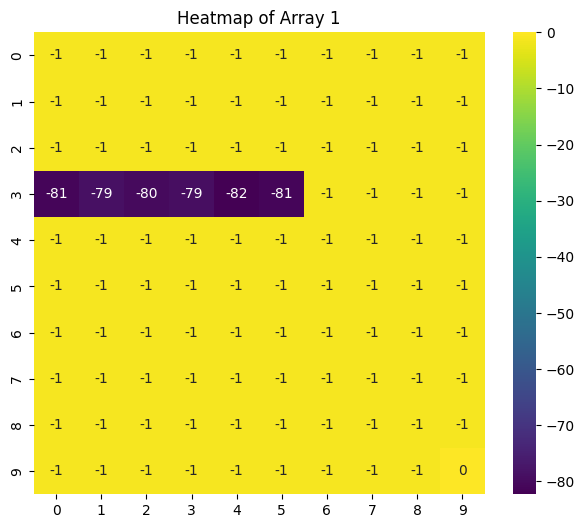

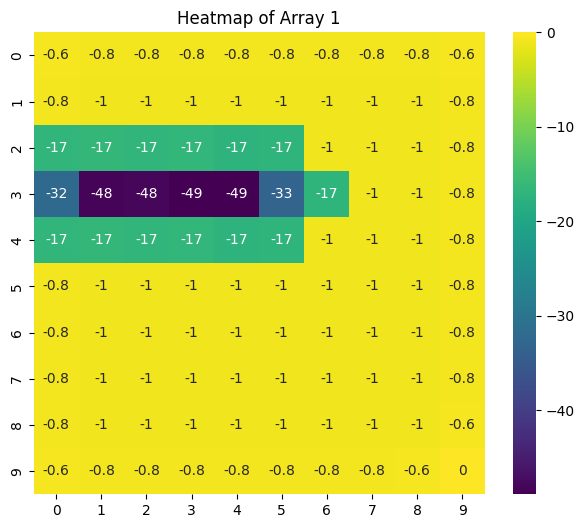

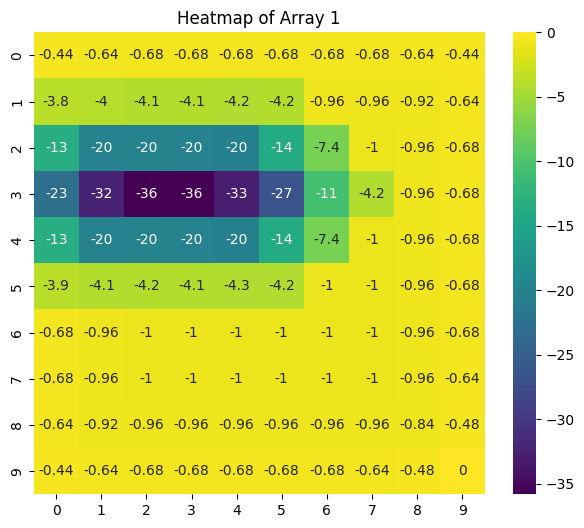

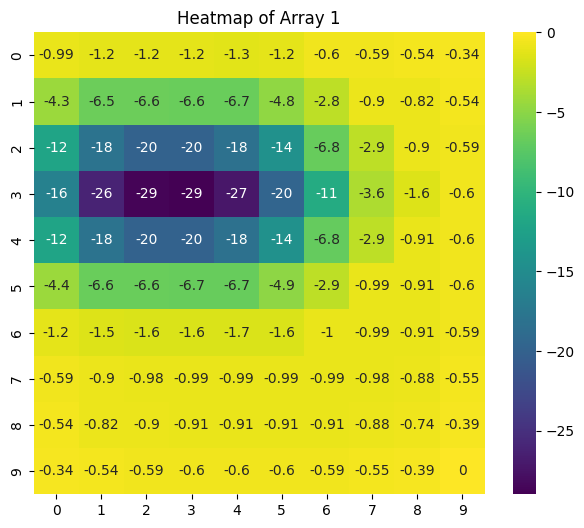

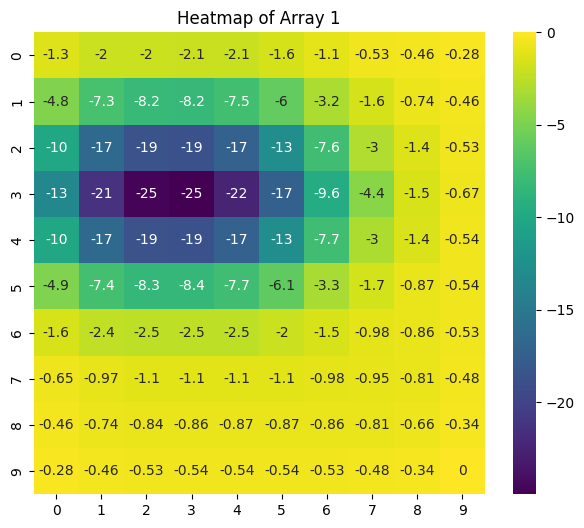

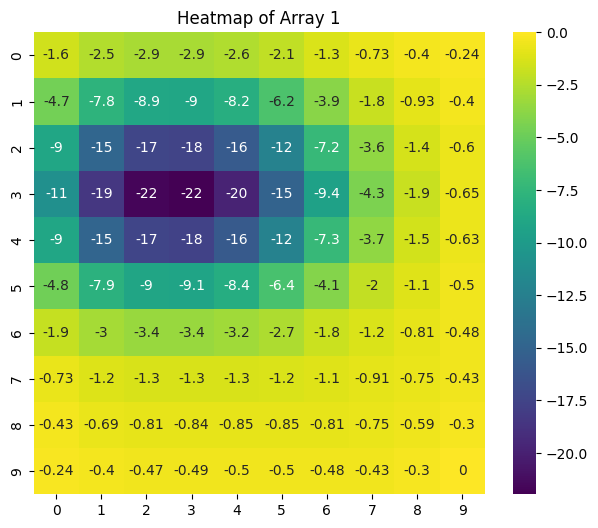

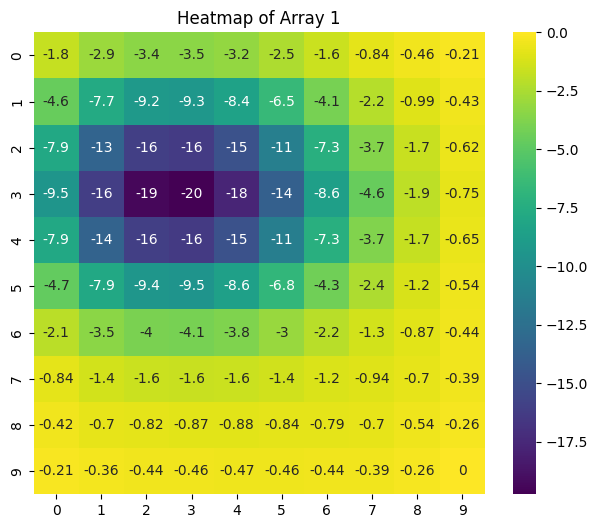

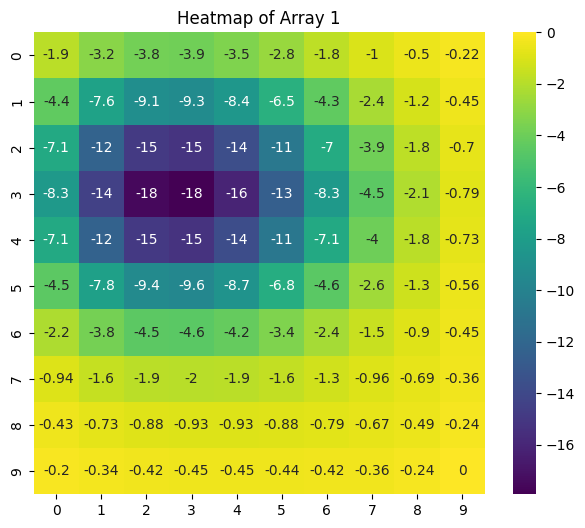

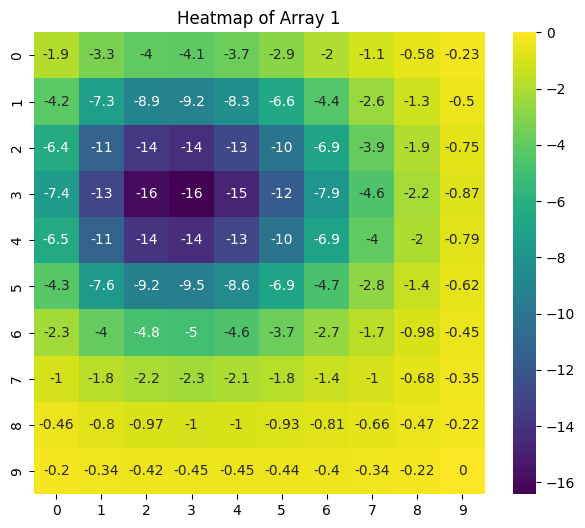

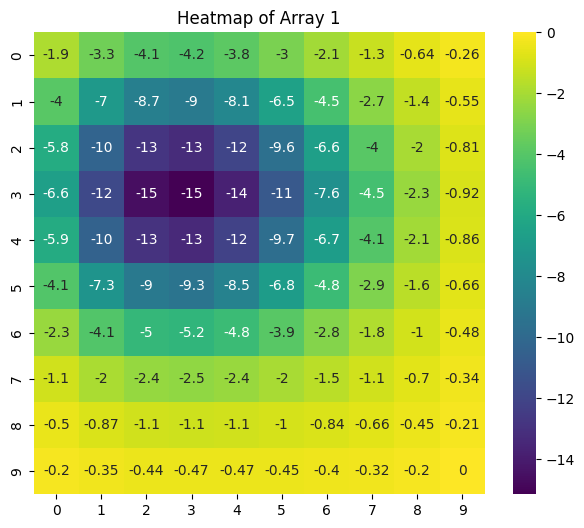

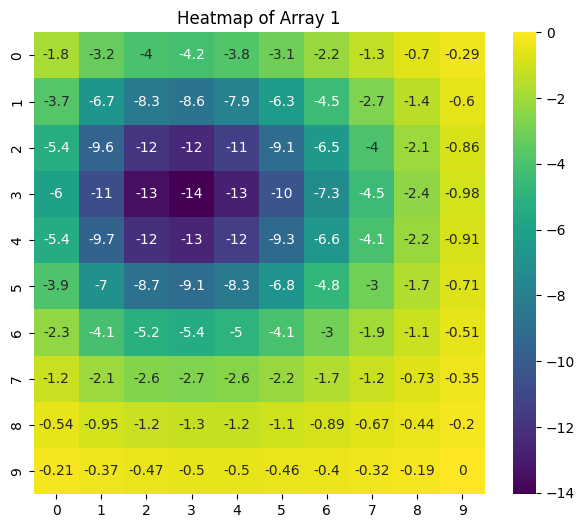

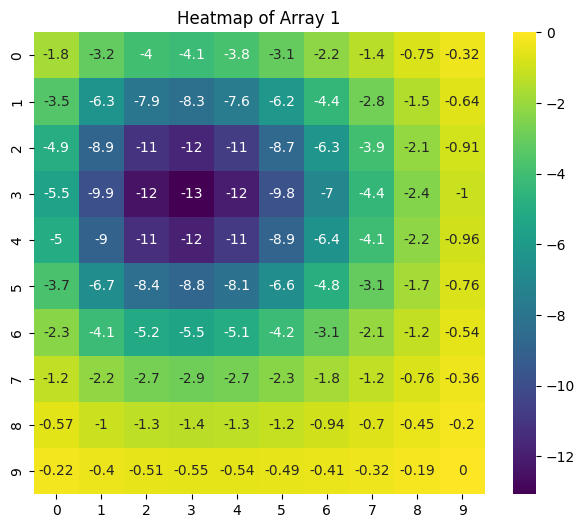

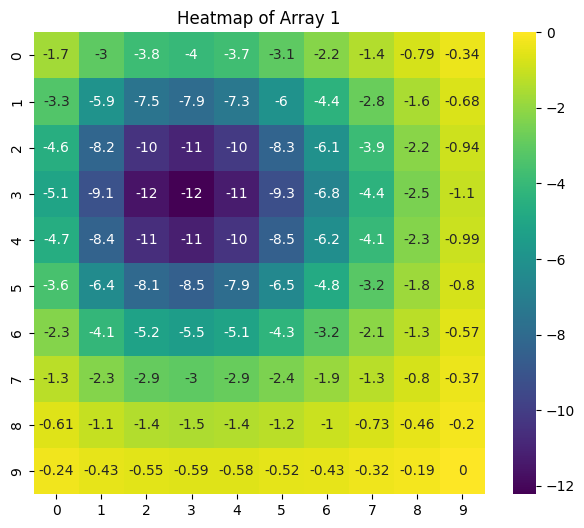

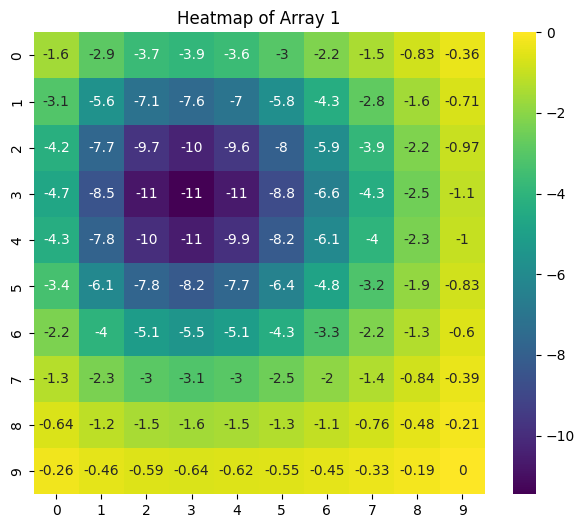

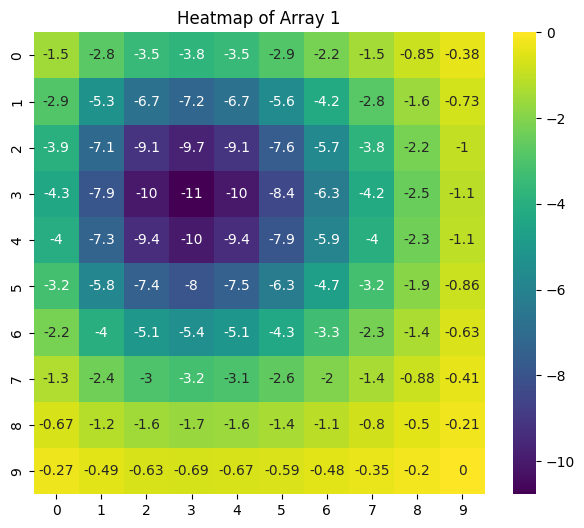

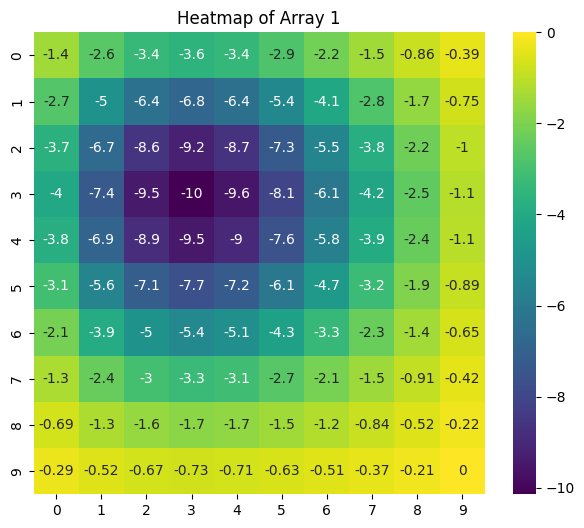

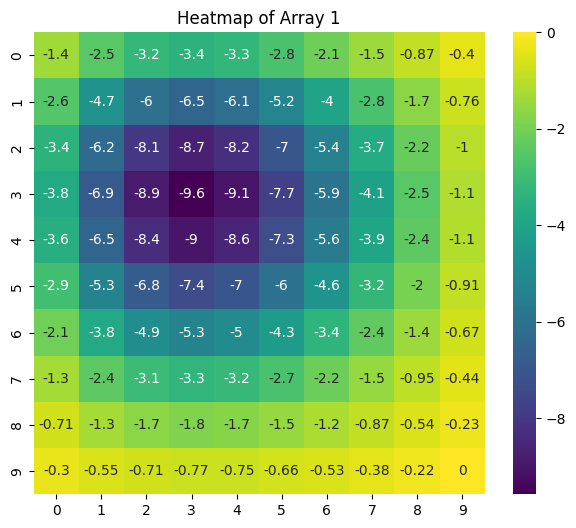

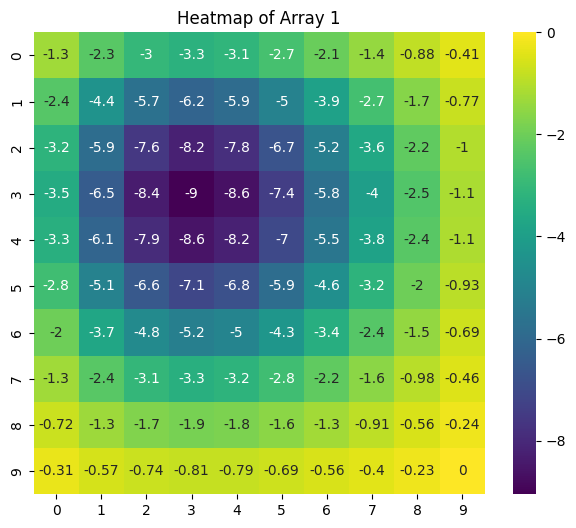

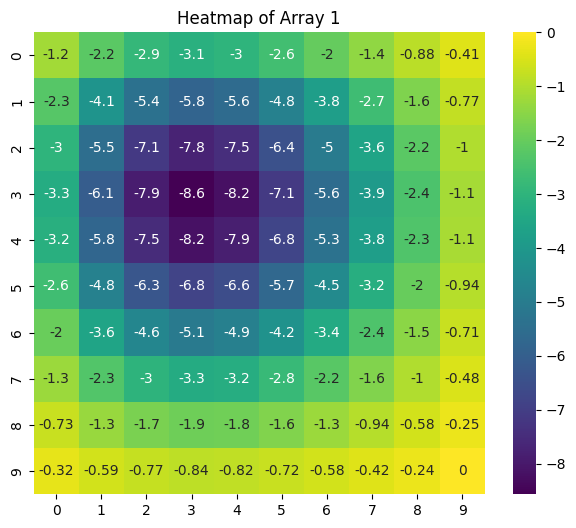

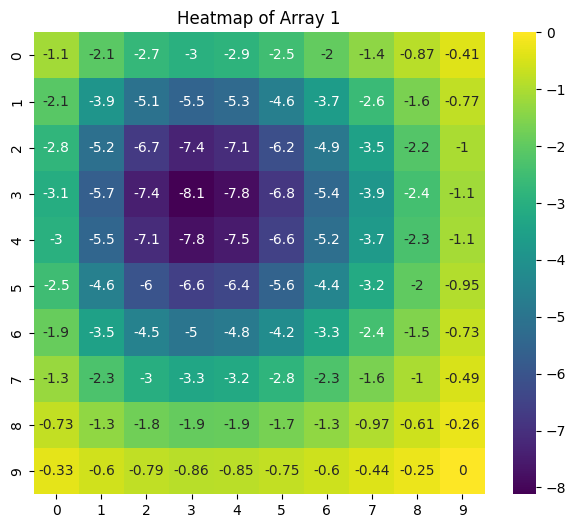

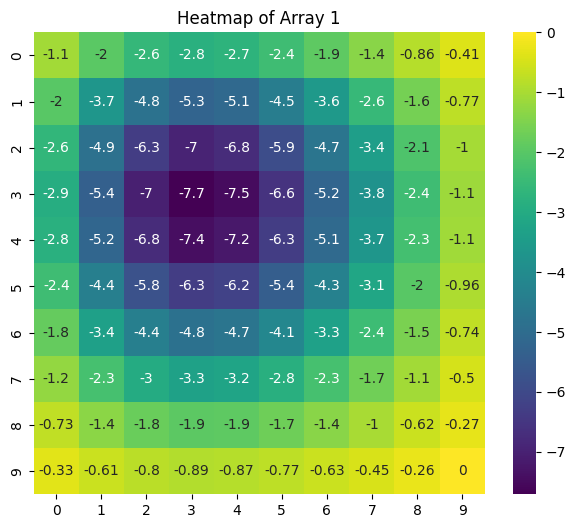

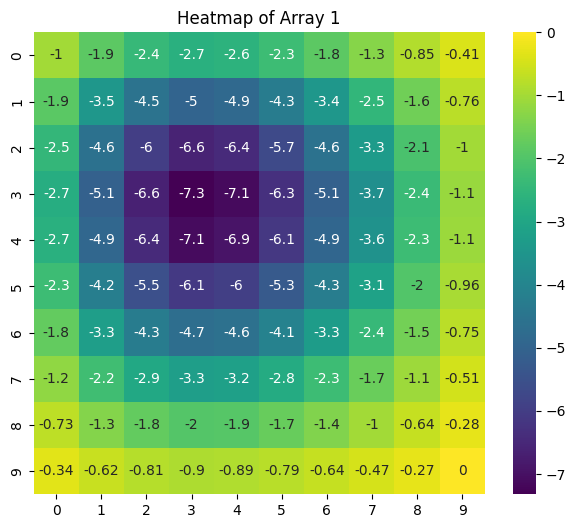

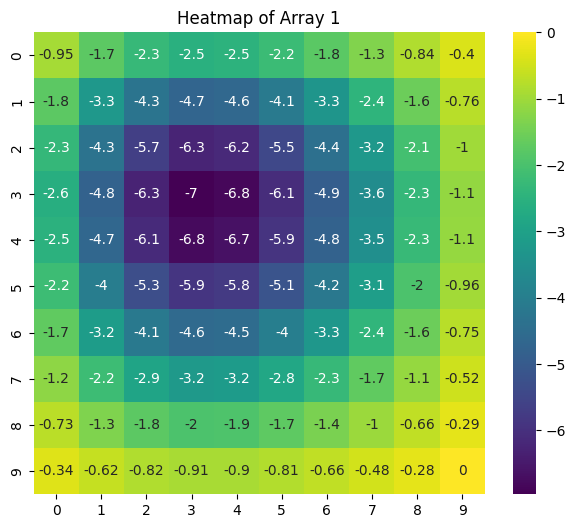

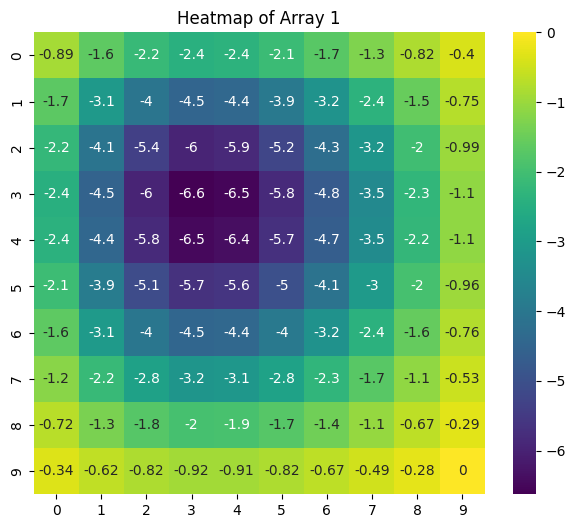

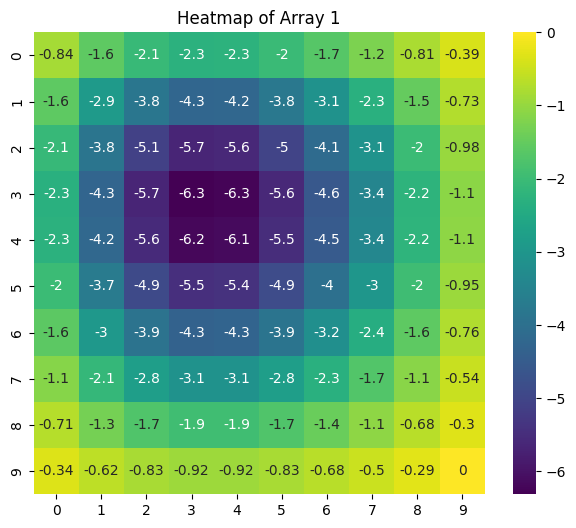

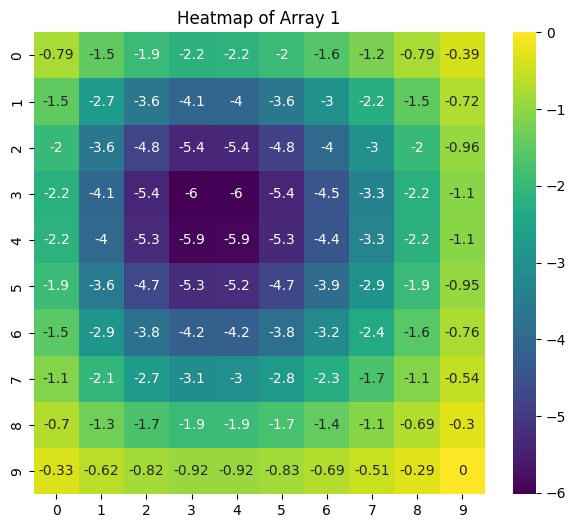

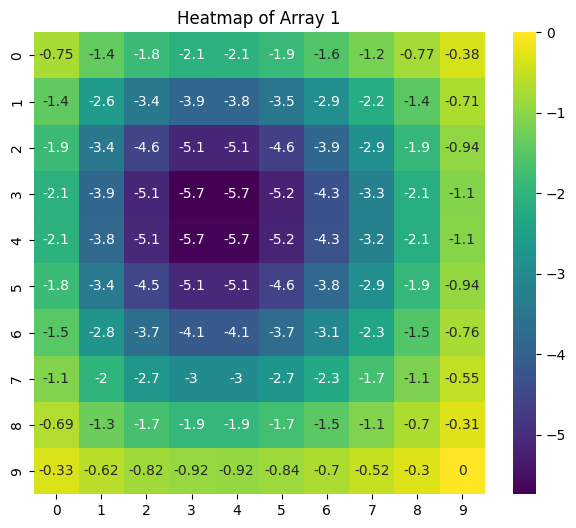

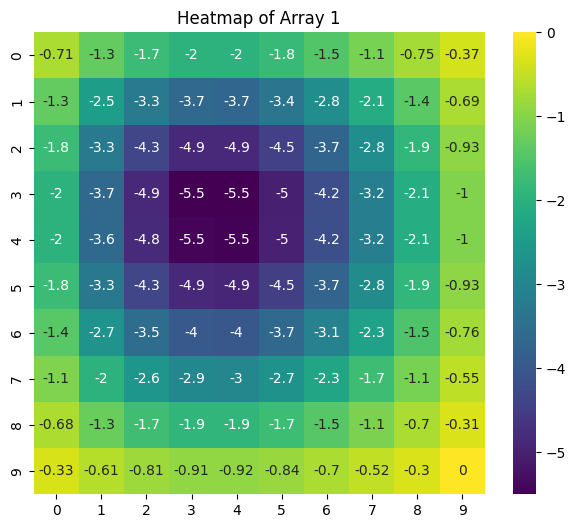

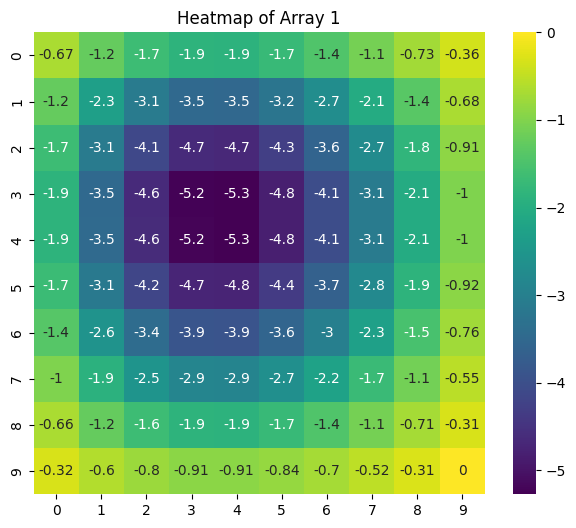

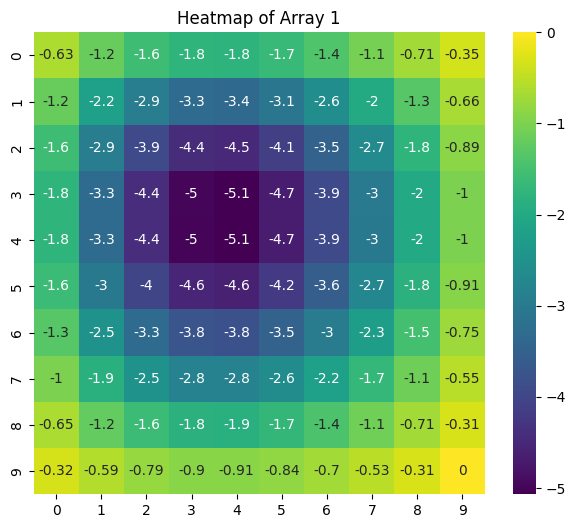

In [ ]:
from scipy.ndimage import convolve


env=GridworldWithWalls()

## Step 1: mapping:
Q = {state: {action: 0 for action in env.get_possible_actions()} for state in [(x, y) for x in range(env.size) for y in range(env.size)]}
Count=100000
state = env.reset()

reward_map=np.full((env.size,env.size),0)
cnt_map=np.full((env.size,env.size),0)

print(reward_map)



def custom_convolve2d(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape

    # Flip the kernel for convolution (if necessary, depending on the convention you follow)
    kernel = np.flipud(np.fliplr(kernel))

    # Calculate padding
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    # Pad image with zeros on all sides
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), 'constant')

    # Initialize the output array with zeros
    output = np.zeros_like(image, dtype=float)  # Ensure output type matches input

    # Perform the convolution operation
    for y in range(image_height):
        for x in range(image_width):
            # Extract the current region of interest
            region = padded_image[y:y+kernel_height, x:x+kernel_width]
            # Perform element-wise multiplication and sum the result
            output[y, x] = np.sum(region * kernel)

    return output


reward_map=env.rewards
t=0
while t<Count:
  action=random_policy(Q,state)
  state,reward, done=env.step(action)
  cnt_map[state]+=1

  reward_map[state]+=(reward - reward_map[state])/cnt_map[state]

  if done:
      state=env.reset()

  t+=1


print(reward_map)
print(cnt_map)


## Step 2: Convolutions on rewards

# Perform convolution
kernel= np.array([
    [0,   0.2,   0],
    [0.2,   0.2,   0.2],
    [0,   0.2,   0]
])

for i in range(30):
  reward_map[-1,-1]=0

  plt.figure(figsize=(16, 6))

  # Creating the first heatmap
  plt.subplot(1, 2, 1)  # (rows, columns, subplot number)
  sns.heatmap(reward_map, annot=True, cmap='viridis')
  plt.title('Heatmap of Array 1')
  plt.show()
  #print(reward_map)
  reward_map = custom_convolve2d(reward_map, kernel)


In [ ]:
a = np.array([[0.1, 0.2, 0, 0],[0.5, 0.3, 0, 0.4],[0, 0, 0, 0.7],[0.9, 0.9, 0.3, 0]])
k = np.array([[1,1,1],[1,1,0],[1,0,0]])
from scipy import ndimage


a=np.array([[ -1 , -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
    [ -1 , -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
    [ -1 , -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
    [ -1 , -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
    [ -1 , -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
    [ -1 , -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
    [ -1 , -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
    [ -1 , -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
    [ -1 , -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
  [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, 100]])


k=np.array([[0,0.2,0],[0.2,0.2,0.2],[0,0.1,0]])
print(ndimage.convolve(a, k, mode='constant', cval=0.0))


def custom_convolve2d(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape

    # Flip the kernel for convolution (if necessary, depending on the convention you follow)
    kernel = np.flipud(np.fliplr(kernel))

    # Calculate padding
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    # Pad image with zeros on all sides
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), 'constant')

    # Initialize the output array with zeros
    output = np.zeros_like(image, dtype=float)  # Ensure output type matches input

    # Perform the convolution operation
    for y in range(image_height):
        for x in range(image_width):
            # Extract the current region of interest
            region = padded_image[y:y+kernel_height, x:x+kernel_width]
            # Perform element-wise multiplication and sum the result
            output[y, x] = np.sum(region * kernel)

    return output


print(custom_convolve2d(a,k))

[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19]
 [ 0  0  0  0  0  0  0  0 19 19]]
[[-0.6 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.6]
 [-0.7 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.7]
 [-0.7 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.7]
 [-0.7 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.7]
 [-0.7 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.7]
 [-0.7 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.7]
 [-0.7 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.7]
 [-0.7 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.7]
 [-0.7 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 19.5]
 [-0.5 -0.7 -0.7 -0.7 -0.7 -0.7 -0.7 -0.7 19.5 19.7]]
